In [1]:
pip install torch transformers scikit-learn pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Singular Value Decomposition (SVD) with PyTorch

This notebook demonstrates how to perform SVD using PyTorch with various examples and applications.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import linalg
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Create device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda


## Basic SVD with PyTorch

SVD decomposes a matrix A into three matrices: A = U @ S @ V^T
- U: left singular vectors (orthogonal)
- S: singular values (diagonal)  
- V^T: right singular vectors (orthogonal)


In [3]:
# Create a sample matrix
A = torch.randn(5, 4, device=device, dtype=torch.float32)
print("Original matrix A:")
print(A)
print(f"Shape of A: {A.shape}")

# Perform SVD
U, S, Vt = torch.linalg.svd(A, full_matrices=False)

print(f"\nShapes after SVD:")
print(f"U: {U.shape}")
print(f"S: {S.shape}")  
print(f"Vt: {Vt.shape}")

print(f"\nSingular values:")
print(S)

# Verify the decomposition: A = U @ diag(S) @ Vt
A_reconstructed = U @ torch.diag(S) @ Vt
print(f"\nReconstruction error (should be close to 0):")
print(torch.norm(A - A_reconstructed).item())


Original matrix A:
tensor([[ 0.1940,  2.1614, -0.1721,  0.8491],
        [-1.9244,  0.6530, -0.6494, -0.8175],
        [ 0.5280, -1.2753, -1.6621, -0.3033],
        [-0.0926,  0.1992, -1.1204,  1.8577],
        [-0.7145,  0.6881,  0.7968, -0.0334]], device='cuda:0')
Shape of A: torch.Size([5, 4])

Shapes after SVD:
U: torch.Size([5, 4])
S: torch.Size([4])
Vt: torch.Size([4, 4])

Singular values:
tensor([3.0149, 2.6019, 2.1760, 1.1044], device='cuda:0')

Reconstruction error (should be close to 0):
4.917924798064632e-06


## Low-Rank Approximation with SVD

SVD can be used for dimensionality reduction by keeping only the k largest singular values.


Original matrix shape: torch.Size([100, 50])
Number of singular values: 50
Largest singular values: tensor([17.3134, 16.1679, 15.9385, 15.0620, 14.5525, 14.3169, 14.0004, 13.7046,
        13.2183, 12.9968], device='cuda:0')


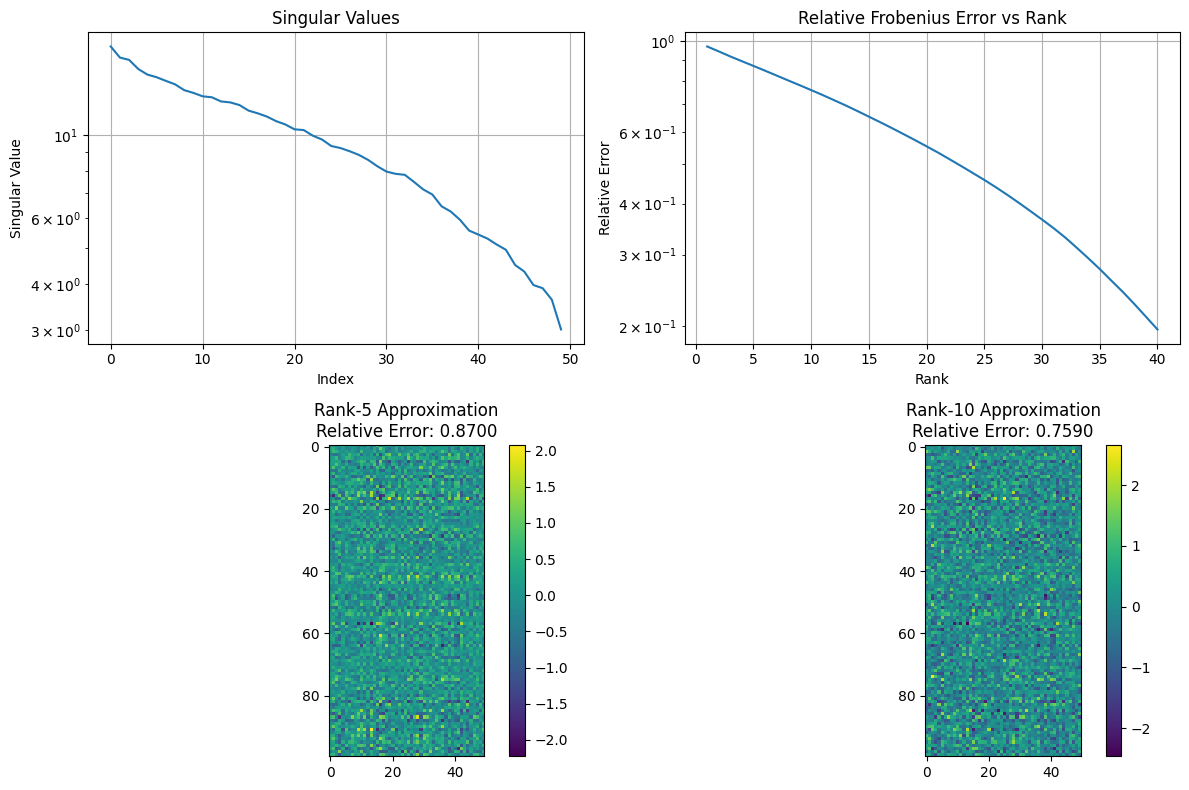

Rank 5: Error = 0.869987, Compression = 6.67x
Rank 10: Error = 0.758994, Compression = 3.33x
Rank 20: Error = 0.552532, Compression = 1.67x
Rank 30: Error = 0.365620, Compression = 1.11x


In [4]:
# Create a larger matrix for low-rank approximation
A_large = torch.randn(100, 50, device=device)
print(f"Original matrix shape: {A_large.shape}")

# Perform SVD
U, S, Vt = torch.linalg.svd(A_large)

# Analyze singular values
print(f"Number of singular values: {len(S)}")
print(f"Largest singular values: {S[:10]}")

# Create low-rank approximations with different numbers of components
ranks = [5, 10, 20, 30]

plt.figure(figsize=(12, 8))

# Plot singular values
plt.subplot(2, 2, 1)
plt.semilogy(S.cpu().numpy())
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)

# Plot approximation errors
errors = []
for k in range(1, min(len(S), 40) + 1):
    # Low-rank approximation
    A_k = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
    error = torch.norm(A_large - A_k, 'fro').item() / torch.norm(A_large, 'fro').item()
    errors.append(error)

plt.subplot(2, 2, 2)
plt.plot(range(1, len(errors) + 1), errors)
plt.title('Relative Frobenius Error vs Rank')
plt.xlabel('Rank')
plt.ylabel('Relative Error')
plt.grid(True)
plt.yscale('log')

# Show approximations for specific ranks
for i, k in enumerate(ranks[:2]):
    A_k = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
    error = torch.norm(A_large - A_k, 'fro').item() / torch.norm(A_large, 'fro').item()
    
    plt.subplot(2, 2, 3 + i)
    plt.imshow(A_k.cpu().numpy(), cmap='viridis')
    plt.title(f'Rank-{k} Approximation\nRelative Error: {error:.4f}')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Print compression information
for k in ranks:
    original_size = A_large.numel()
    compressed_size = k * (A_large.shape[0] + A_large.shape[1])
    compression_ratio = original_size / compressed_size
    A_k = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
    error = torch.norm(A_large - A_k, 'fro').item() / torch.norm(A_large, 'fro').item()
    
    print(f"Rank {k}: Error = {error:.6f}, Compression = {compression_ratio:.2f}x")


## SVD for Image Compression

A practical application of SVD is image compression, where we can approximate images using fewer singular values.


Image shape: torch.Size([128, 128])


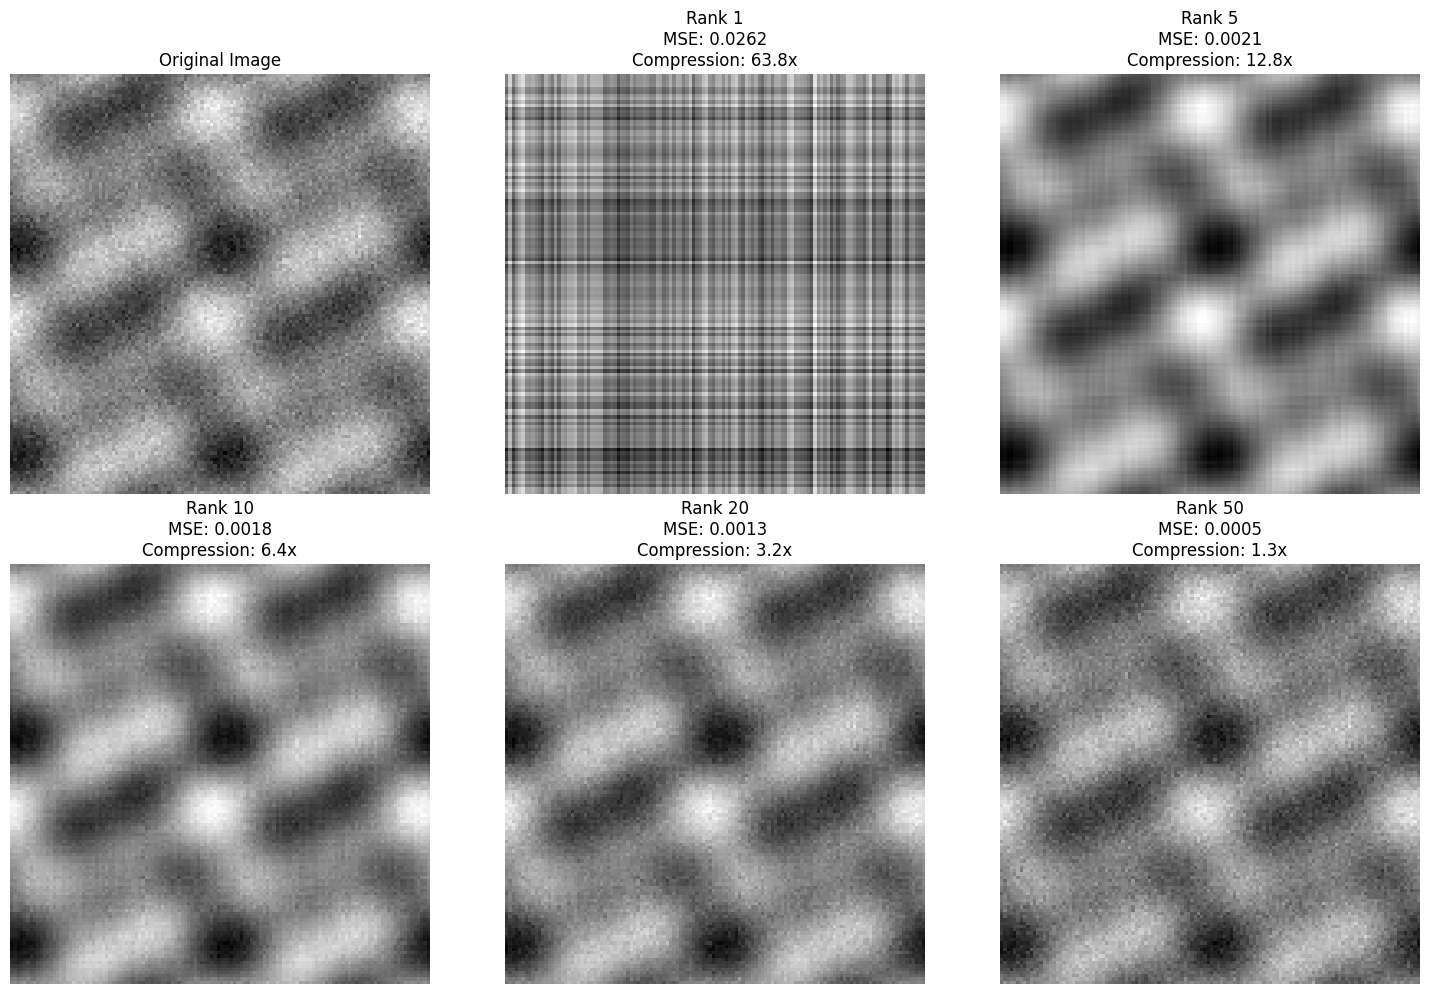

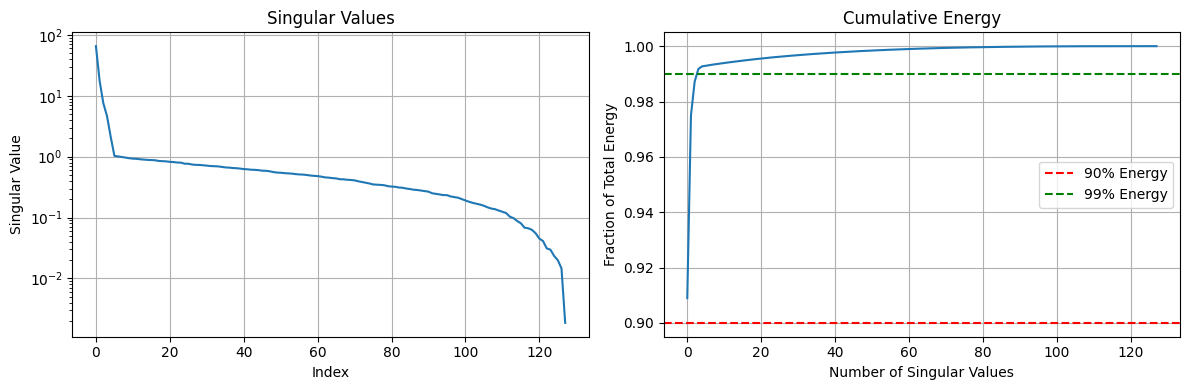


Energy Analysis:
Rank needed for 90% energy: 1
Rank needed for 99% energy: 4
Total singular values: 128

Compression analysis:
 50.0% quality: rank   1, compression 63.8x
 80.0% quality: rank   1, compression 63.8x
 90.0% quality: rank   1, compression 63.8x
 95.0% quality: rank   2, compression 31.9x
 99.0% quality: rank   4, compression 15.9x


In [5]:
# Create a synthetic image (or load a real image if available)
def create_synthetic_image(height, width):
    """Create a synthetic image with various patterns"""
    x = torch.linspace(0, 4*np.pi, width, device=device)
    y = torch.linspace(0, 4*np.pi, height, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # Create a pattern with multiple frequency components
    image = (torch.sin(X) * torch.cos(Y) + 
             0.5 * torch.sin(2*X + Y) + 
             0.3 * torch.sin(X - 2*Y) +
             0.2 * torch.randn_like(X))  # Add some noise
    
    # Normalize to [0, 1]
    image = (image - image.min()) / (image.max() - image.min())
    return image

# Create synthetic image
height, width = 128, 128
original_image = create_synthetic_image(height, width)
print(f"Image shape: {original_image.shape}")

# Perform SVD
U, S, Vt = torch.linalg.svd(original_image)

# Visualize the original image and various approximations
ranks_to_show = [1, 5, 10, 20, 50]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Show original image
axes[0].imshow(original_image.cpu().numpy(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show approximations
for i, k in enumerate(ranks_to_show):
    if i >= 5:  # We only have 5 subplots after the original
        break
    
    # Low-rank approximation
    approx_image = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
    
    # Calculate compression ratio and error
    original_size = height * width
    compressed_size = k * (height + width + 1)  # U[:, :k] + S[:k] + Vt[:k, :]
    compression_ratio = original_size / compressed_size
    
    # Calculate MSE
    mse = torch.mean((original_image - approx_image)**2).item()
    
    axes[i+1].imshow(approx_image.cpu().numpy(), cmap='gray')
    axes[i+1].set_title(f'Rank {k}\nMSE: {mse:.4f}\nCompression: {compression_ratio:.1f}x')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Plot singular values and cumulative energy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Singular values
ax1.semilogy(S.cpu().numpy())
ax1.set_title('Singular Values')
ax1.set_xlabel('Index')
ax1.set_ylabel('Singular Value')
ax1.grid(True)

# Cumulative energy
energy = S**2
cumulative_energy = torch.cumsum(energy, dim=0) / torch.sum(energy)

ax2.plot(cumulative_energy.cpu().numpy())
ax2.set_title('Cumulative Energy')
ax2.set_xlabel('Number of Singular Values')
ax2.set_ylabel('Fraction of Total Energy')
ax2.grid(True)
ax2.axhline(y=0.9, color='r', linestyle='--', label='90% Energy')
ax2.axhline(y=0.99, color='g', linestyle='--', label='99% Energy')
ax2.legend()

plt.tight_layout()
plt.show()

# Find rank needed for 90% and 99% energy retention
energy_90_idx = torch.argmax((cumulative_energy >= 0.9).float()).item()
energy_99_idx = torch.argmax((cumulative_energy >= 0.99).float()).item()

print(f"\nEnergy Analysis:")
print(f"Rank needed for 90% energy: {energy_90_idx + 1}")
print(f"Rank needed for 99% energy: {energy_99_idx + 1}")
print(f"Total singular values: {len(S)}")

# Calculate compression ratios for different quality levels
qualities = [0.5, 0.8, 0.9, 0.95, 0.99]
print(f"\nCompression analysis:")
for quality in qualities:
    rank_needed = torch.argmax((cumulative_energy >= quality).float()).item() + 1
    compression_ratio = (height * width) / (rank_needed * (height + width + 1))
    print(f"{quality*100:5.1f}% quality: rank {rank_needed:3d}, compression {compression_ratio:.1f}x")


## Advanced SVD Features & Tips


In [6]:
# Advanced SVD features and considerations

print("=== SVD with different precisions ===")
# SVD with different data types
A_float32 = torch.randn(10, 8, device=device, dtype=torch.float32)
A_float64 = A_float32.double()

# Compare precision
U32, S32, Vt32 = torch.linalg.svd(A_float32, full_matrices=False)
U64, S64, Vt64 = torch.linalg.svd(A_float64, full_matrices=False)

print(f"Float32 reconstruction error: {torch.norm(A_float32 - U32 @ torch.diag(S32) @ Vt32).item():.2e}")
print(f"Float64 reconstruction error: {torch.norm(A_float64 - U64 @ torch.diag(S64) @ Vt64).item():.2e}")

print("\n=== SVD for solving linear systems ===")
# SVD can be used to solve Ax = b (especially for ill-conditioned systems)
A = torch.randn(5, 5, device=device)
b = torch.randn(5, device=device)

# Make A slightly ill-conditioned for demonstration
A = A + 1e-10 * torch.eye(5, device=device)

# Solve using SVD
U, S, Vt = torch.linalg.svd(A)

# Pseudoinverse solution: x = V @ diag(1/S) @ U^T @ b
# Handle near-zero singular values
tolerance = 1e-12
S_inv = torch.where(S > tolerance, 1.0 / S, torch.zeros_like(S))
x_svd = Vt.T @ torch.diag(S_inv) @ U.T @ b

# Compare with direct solution
x_direct = torch.linalg.solve(A, b)

print(f"Direct solution residual: {torch.norm(A @ x_direct - b).item():.2e}")
print(f"SVD solution residual: {torch.norm(A @ x_svd - b).item():.2e}")
print(f"Solution difference: {torch.norm(x_direct - x_svd).item():.2e}")

print("\n=== Matrix condition number ===")
# Condition number is ratio of largest to smallest singular value
condition_numbers = []
matrix_sizes = [5, 10, 20, 50]

for size in matrix_sizes:
    A = torch.randn(size, size, device=device)
    U, S, Vt = torch.linalg.svd(A)
    condition_num = S[0] / S[-1]
    condition_numbers.append(condition_num.item())
    print(f"Matrix {size}x{size}: condition number = {condition_num.item():.2e}")

print("\n=== Memory considerations ===")
# For very large matrices, consider using reduced SVD
large_matrix = torch.randn(1000, 100, device=device)

# Full SVD
U_full, S_full, Vt_full = torch.linalg.svd(large_matrix, full_matrices=True)
print(f"Full SVD - U: {U_full.shape}, S: {S_full.shape}, Vt: {Vt_full.shape}")

# Reduced SVD (default)
U_reduced, S_reduced, Vt_reduced = torch.linalg.svd(large_matrix, full_matrices=False)
print(f"Reduced SVD - U: {U_reduced.shape}, S: {S_reduced.shape}, Vt: {Vt_reduced.shape}")

# Memory usage comparison
full_memory = U_full.numel() + S_full.numel() + Vt_full.numel()
reduced_memory = U_reduced.numel() + S_reduced.numel() + Vt_reduced.numel()
print(f"Memory reduction: {full_memory / reduced_memory:.1f}x")

print("\n=== Gradient computation with SVD ===")
# SVD is differentiable in PyTorch
A = torch.randn(3, 3, device=device, requires_grad=True)
U, S, Vt = torch.linalg.svd(A)

# Example: minimize the nuclear norm (sum of singular values)
loss = torch.sum(S)
loss.backward()

print(f"Nuclear norm: {loss.item():.4f}")
print(f"Gradient norm: {torch.norm(A.grad).item():.4f}")

print("\n=== Performance tips ===")
print("1. Use full_matrices=False for tall/wide matrices to save memory")
print("2. Use float32 for faster computation if precision allows")
print("3. Consider torch.linalg.svdvals() if you only need singular values")
print("4. For very large matrices, consider iterative methods or randomized SVD")
print("5. SVD is differentiable, so it works with autograd")

# Demonstrate svdvals for singular values only
A = torch.randn(100, 50, device=device)
S_only = torch.linalg.svdvals(A)
print(f"\nSingular values only: {S_only.shape}")


=== SVD with different precisions ===
Float32 reconstruction error: 1.26e-05
Float64 reconstruction error: 3.15e-14

=== SVD for solving linear systems ===
Direct solution residual: 7.44e-07
SVD solution residual: 1.27e-06
Solution difference: 3.14e-06

=== Matrix condition number ===
Matrix 5x5: condition number = 5.88e+00
Matrix 10x10: condition number = 2.35e+01
Matrix 20x20: condition number = 5.41e+01
Matrix 50x50: condition number = 9.10e+01

=== Memory considerations ===
Full SVD - U: torch.Size([1000, 1000]), S: torch.Size([100]), Vt: torch.Size([100, 100])
Reduced SVD - U: torch.Size([1000, 100]), S: torch.Size([100]), Vt: torch.Size([100, 100])
Memory reduction: 9.2x

=== Gradient computation with SVD ===
Nuclear norm: 4.2133
Gradient norm: 1.7321

=== Performance tips ===
1. Use full_matrices=False for tall/wide matrices to save memory
2. Use float32 for faster computation if precision allows
3. Consider torch.linalg.svdvals() if you only need singular values
4. For very lar